In [21]:
!pip install yfinance
!pip install seaborn
!pip install matplotlib
!pip install pandas
!pip install scipy
!pip install statsmodels
!pip install arch
!pip install pmdarima

In [22]:
import yfinance as yf
data = yf.download('AMSWA')

# download data from Yahoo Finance and save it as csv file
data.to_csv('GOOG.csv')

# load data from csv file
import pandas as pd
# data = pd.read_csv('GOOG.csv')
df = data.reset_index()
print(df.columns)

[*********************100%%**********************]  1 of 1 completed

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


### TASK-1: Plot the prices for the given data.

<Axes: xlabel='Date', ylabel='Adj Close'>

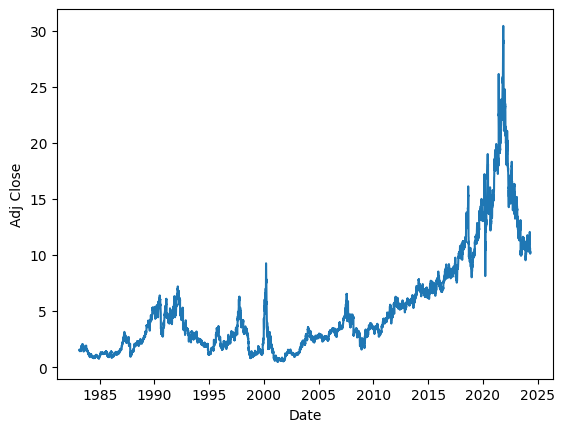

In [23]:
import seaborn as sns
sns.lineplot(data=df, x='Date', y='Adj Close')

### TASK-2: Plot log-returns for the given data.

<Axes: xlabel='Date', ylabel='log_ret'>

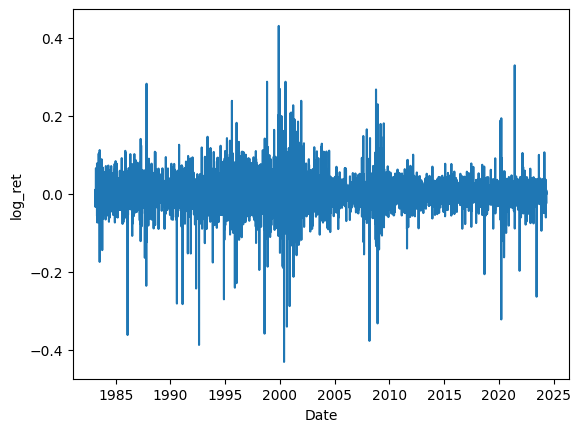

In [24]:
import numpy as np
df['log_ret'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
df.fillna({'log_ret': 0}, inplace=True)
import seaborn as sns
sns.lineplot(data=df, x='Date', y='log_ret')

### Task-3: Check whether log-returns are normally distributed using QQ plot,histogram and other statistical test like (Jerq-Berra, Kolmogorov-Smirnov test)

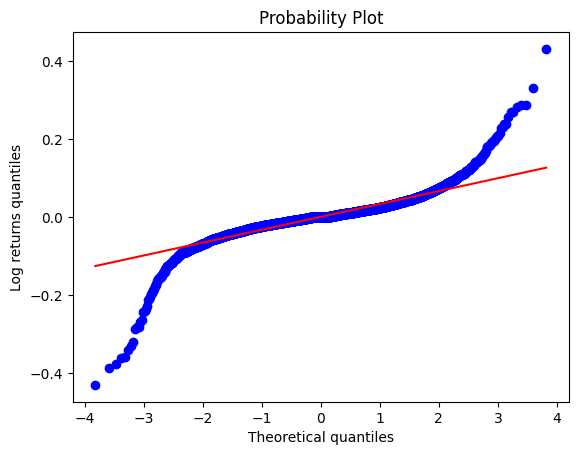

In [25]:
# check if the log returns are normally distributed using a Q-Q plot
import matplotlib.pyplot as plt
import scipy.stats as stats
stats.probplot(df['log_ret'], dist="norm", plot=plt)
plt.ylabel('Log returns quantiles')
plt.show()

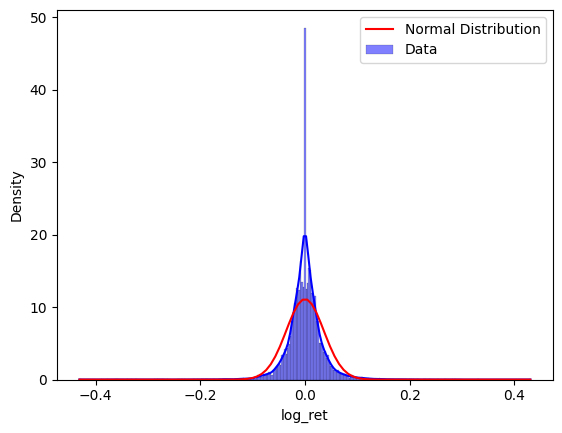

In [26]:
# check if the log returns are normally distributed using histogram
sns.histplot(df['log_ret'], kde=True, stat='density', label='Data', color='blue')

# plot the expected normal distribution
x = np.linspace(df['log_ret'].min(), df['log_ret'].max(), 100)
y = stats.norm.pdf(x, df['log_ret'].mean(), df['log_ret'].std())
plt.plot(x, y, label='Normal Distribution', color='red')

# Add a legend
plt.legend()

# Show the plot
plt.show()

- As can be seen from the QQ plot, the log-returns are not normally distributed.
- The histogram also shows that the log-returns are not normally distributed.

In [27]:
# perform Jerq-Berra test for normality
jb_test = stats.jarque_bera(df['log_ret'])
print(f"jerq-Berra test: {jb_test}")
if jb_test.pvalue < 0.05:
    print('The log returns are not normally distributed')
else:
    print('The log returns are normally distributed')

jerq-Berra test: SignificanceResult(statistic=156820.98244824857, pvalue=0.0)
The log returns are not normally distributed


In [28]:
# perform Kolmogorov-Smirnov test for normality
ks_test = stats.kstest(df['log_ret'], 'norm')
print(f"Kolmogorov-Smirnov test: {ks_test}")
if ks_test.pvalue < 0.05:
    print('The log returns are not normally distributed')
else:
    print('The log returns are normally distributed')

Kolmogorov-Smirnov test: KstestResult(statistic=0.454046740270102, pvalue=0.0, statistic_location=-0.09237331578463026, statistic_sign=-1)
The log returns are not normally distributed


### Task-4: Estimate the historical volatility using log returns.

Annualized Historical volatility: 0.40456327213623305


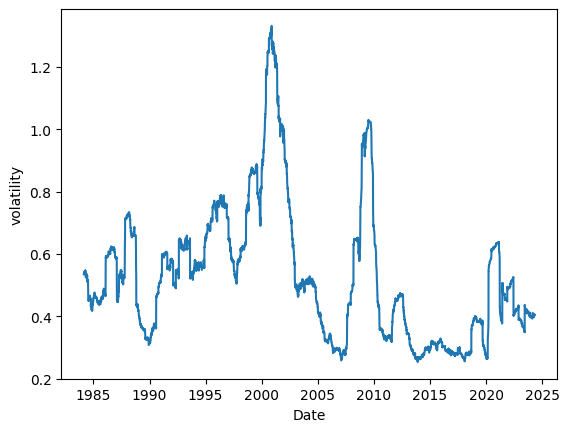

In [42]:
# Estimate trend of annualized historical volatility using log returns. (window = 252 days)
df['volatility'] = df['log_ret'].rolling(window=252).std() * np.sqrt(252)
df['volatility'].dropna(inplace=True)
sns.lineplot(data=df, x='Date', y='volatility')
hist_vol = df['volatility'].iloc[-1]

# print the annualized historical volatility for last 252 days
print(f"Annualized Historical volatility: {hist_vol}")

### Task-5: Identify the risk free rate for the given currency (3-Months treasury rate for the currency

In [30]:
#Identify the risk free rate for USD (3-Months treasury rate for the currency)
data = yf.download('^IRX',period='3m')
risk_free_rate = data['Adj Close'].mean() / 100
print(f"3 month risk free rate: {risk_free_rate*100}")
# risk_free_rate = 0.05238

[*********************100%%**********************]  1 of 1 completed

3 month risk free rate: 5.248000144958496


### Task-6: Test the assumption if the log-returns are independent/uncorrelated.

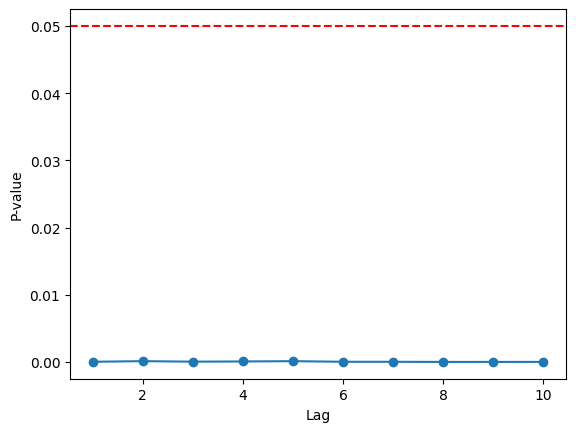

The log returns are autocorrelated


In [31]:
# Ljung-Box Test: to check if the log returns are independent/uncorrelated
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(df['log_ret'], lags=10)

# Plot the p-values
plt.plot(lb_test.lb_pvalue, marker='o')  
plt.axhline(0.05, color='red', linestyle='--')
plt.xlabel('Lag')
plt.ylabel('P-value')
plt.show()

# if any of the p-values is less than 0.05, the log returns are autocorrelated
if any(lb_test["lb_pvalue"] < 0.05):
    print('The log returns are autocorrelated')
else:
    print('The log returns are not autocorrelated')



<Figure size 1000x200 with 0 Axes>

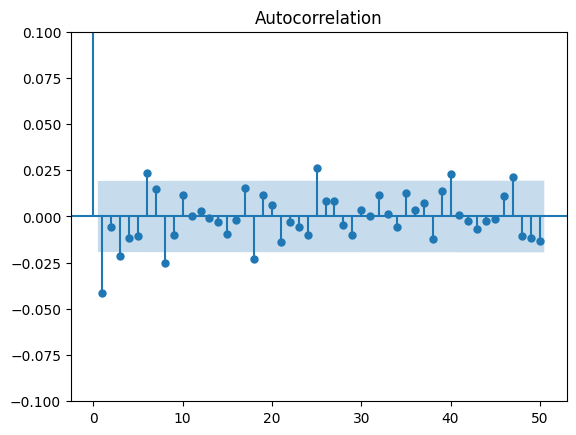

In [32]:
# using ACF plot
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(10, 2))
plot_acf(df['log_ret'], lags=50)
plt.ylim(-0.1, 0.1)  # Change the scale of the y-axis
plt.show()

In [33]:
def runs_test(log_returns):
  """
  performs a Runs Test to assess independence in log returns.
  """
  n = len(log_returns)
  num_runs = 1  # Initialize number of runs

  # Iterate through log returns, checking for changes in sign
  for i in range(1, n):
    if log_returns[i] * log_returns[i-1] < 0:  # Check for sign change
      num_runs += 1

  # Calculate expected number of runs and standard deviation
  expected_runs = (2 * n - 1) / 3
  std_deviation = np.sqrt((16 * n - 29) / 90)

  # Calculate z-score
  z_score = (num_runs - expected_runs) / std_deviation

  return num_runs, expected_runs, std_deviation, z_score

_,_,_, z_score = runs_test(df['log_ret'])

print("Z-Score:", z_score)

if abs(z_score) > 1.96:
    print('The log returns are not independent/auto-correlated')
else:
    print('The log returns are independent')

Z-Score: -57.21454252252986
The log returns are not independent/auto-correlated


both run test, ACF plot and Ljung-box test shows that the log returns show correlation.

### Task-7: Calculate the option price for an In-The-Money (ITM) European call option and In-The-Money European put option for the maturity May 31, 2024. The pricing date can be taken on which you calculate the option price.

In [34]:
import numpy as np
import math
# Base class for option pricing
class OptionPricing():
    def __init__(self, S, K_call,K_put, r, T, sigma):
        self.S = S
        self.K_call = K_call
        self.K_put = K_put
        self.r = r
        self.T = T
        self.sigma = sigma
    def call_price(self):
        pass
    def put_price(self):
        pass
    def price(self, option_type):
        if option_type == 'call':
            call_price =  self.call_price()
            return call_price
        elif option_type == 'put':
            put_price  = self.put_price()
            return put_price
        else:
            raise ValueError('Option type must be either "call" or "put"')
    

# Black-Scholes model for option pricing
class BlackScholes(OptionPricing):
    def __init__(self, S, K_call,K_put, r, T, sigma):
        super().__init__(S, K_call,K_put, r, T, sigma)
        
    def call_price(self):
        self.d1 = (np.log(self.S / self.K_call) + (self.r + 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
        self.d2 = self.d1 - self.sigma * np.sqrt(self.T)
        call = self.S * stats.norm.cdf(self.d1) - self.K_call * np.exp(-self.r * self.T) * stats.norm.cdf(self.d2)
        return call

    def put_price(self):
        self.d1 = (np.log(self.S / self.K_put) + (self.r + 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
        self.d2 = self.d1 - self.sigma * np.sqrt(self.T)
        put = self.K_put * np.exp(-self.r * self.T) * stats.norm.cdf(-self.d2) - self.S * stats.norm.cdf(-self.d1)
        return put

# Binomial model for option pricing
class CRR(OptionPricing):
    def __init__(self, S, K_call,K_put, r, T, sigma,n):
        super().__init__(S, K_call,K_put, r, T, sigma)
        self.n = n 
        self.dt = T / self.n # dt: Size of the time step
        self.u = math.exp(sigma * math.sqrt(self.dt)) # u: Factor by which the stock price increases in each time step
        self.d = 1 / self.u # d: Factor by which the stock price decreases in each time step
        self.p = (math.exp(self.r * self.dt) - self.d) / (self.u - self.d) # p: Risk-neutral probability of a price increase
        self.prices = np.zeros((n + 1, n + 1)) # 2D array to store the stock prices in the binomial tree
        self.prices[0, 0] = S

    def price(self, option_type):
        if option_type == 'call':
            return self.call_price(self.n)
        elif option_type == 'put':
            return self.put_price(self.n)
        else:
            raise ValueError('Option type must be either "call" or "put"')
        
    def call_price(self, n=1000):
        return self.crr_option_price('call', n)

    def put_price(self, n=1000):
        return self.crr_option_price('put',n)

    def crr_option_price(self,option_type, n=1000):
        for i in range(1, n + 1):
            self.prices[i, 0] = self.prices[i - 1, 0] * self.u
            for j in range(1, i + 1):
                self.prices[i, j] = self.prices[i - 1, j - 1] * self.d
        option_prices = np.zeros((n + 1, n + 1))
        for j in range(n + 1):
            option_prices[n, j] = max(0, self.prices[n, j] - self.K_call) if option_type == 'call' else max(0, self.K_put - self.prices[n, j])
        for i in range(n - 1, -1, -1):
            for j in range(i + 1):
                option_prices[i, j] = math.exp(-self.r * self.dt) * (self.p * option_prices[i + 1, j] + (1 - self.p) * option_prices[i + 1, j + 1])
        return option_prices[0, 0]

# Monte Carlo Simulation for option pricing   
class SimulationPricing(OptionPricing):
    
    def __init__(self, S, K_call,K_put, r, T, sigma,n, num_simulations):
        super().__init__(S, K_call,K_put, r, T, sigma,)
        self.n = n
        self.num_simulations = num_simulations
        self.T = T
        self.dt = T / self.n
    
    def call_price(self,display_graphs=False):
        return self.simulate_call_option_price(display_graphs=display_graphs)
    
    def put_price(self, display_graphs=False):
        return self.simulate_put_option_price(display_graphs=display_graphs)
    
    def price(self, option_type, display_graphs=False):
        if option_type == 'call':
            return self.call_price(display_graphs=display_graphs)
        elif option_type == 'put':
            return self.put_price(display_graphs=display_graphs)
        else:
            raise ValueError('Option type must be either "call" or "put"')

    def simulate_call_option_price(self, display_graphs=False):
        prices = np.zeros((self.num_simulations, self.n + 1))
        prices[:, 0] = self.S
        for i in range(1, self.n + 1):
            z = np.random.normal(size=self.num_simulations)
            prices[:, i] = prices[:, i - 1] * np.exp((self.r - 0.5 * self.sigma ** 2) * self.dt + self.sigma * np.sqrt(self.dt) * z)
        option_prices = np.maximum(0, prices[:, -1] - self.K_call)
        # also plot the price path for the first 40 simulations
        if display_graphs:
            for i in range(40):
                plt.plot(prices[i])
            plt.xlabel('Time Steps')
            plt.ylabel('Stock Price')
            plt.title('40 Stock Price Path for calculating call option price')
            plt.show()
        return np.mean(option_prices) * np.exp(-self.r * self.T)
    
    def simulate_put_option_price(self, display_graphs=False):
        prices = np.zeros((self.num_simulations, self.n + 1))
        prices[:, 0] = self.S
        for i in range(1, self.n + 1):
            z = np.random.normal(size=self.num_simulations)
            prices[:, i] = prices[:, i - 1] * np.exp((self.r - 0.5 * self.sigma ** 2) * self.dt + self.sigma * np.sqrt(self.dt) * z)
        option_prices = np.maximum(0, self.K_put - prices[:, -1])
        # also plot the price path for the first 40 simulations
        if display_graphs:
            for i in range(40):
                plt.plot(prices[i])
            plt.xlabel('Time Steps')
            plt.ylabel('Stock Price')
            plt.title('40 Stock Price Path for calculating put option price')
        
            plt.show()
        return np.mean(option_prices) * np.exp(-self.r * self.T)
        
    

In [49]:
def getAnalysis(S, K_call,K_put, r, T, sigma):
    # CRR model
    n= 1000
    crrOptionPricing = CRR(S, K_call,K_put, r, T, sigma, n)
    CRR_call_option_price = crrOptionPricing.price("call")
    print(f"CRR: Option price for an In-The-Money European call option: {CRR_call_option_price}")
    CRR_put_option_price = crrOptionPricing.price("put")
    print(f"CRR: Option price for an In-The-Money European put option: {CRR_put_option_price}")
    print()

    # Black-Scholes model
    bsOptionPricing = BlackScholes(S, K_call,K_put, r, T, sigma)
    BS_call_option_price = bsOptionPricing.price("call")
    print(f"BS Model: Option price for an In-The-Money European call option: {BS_call_option_price}")
    BS_put_option_price = bsOptionPricing.price("put")
    print(f"BS Model: Option price for an In-The-Money European put option: {BS_put_option_price}")
    print()

    # Monte Carlo Simulation
    num_simulations = 10000
    n_steps = 10000
    simulatedOptionPricing = SimulationPricing(S, K_call,K_put, r, T, sigma, n_steps, num_simulations)
    simulated_call_option_price = simulatedOptionPricing.simulate_call_option_price(display_graphs=True)
    print(f"Simulation: Option price for an In-The-Money European call option: {simulated_call_option_price}")
    simulated_put_option_price = simulatedOptionPricing.simulate_put_option_price(display_graphs=True)
    print(f"Simulation: Option price for an In-The-Money European put option: {simulated_put_option_price}")
    print()

    # Create a DataFrame to display the option pricing data
    data = {'model': ['Black-Scholes', 'CRR', 'Simulation'],
        'call': [BS_call_option_price, CRR_call_option_price, simulated_call_option_price],
        'put': [BS_put_option_price, CRR_put_option_price, simulated_put_option_price]}
    option_pricing_data = pd.DataFrame(data)
    return option_pricing_data

    
    

##### Setup for the option pricing:

In [50]:
### SETUP ###
import datetime
import pandas as pd
S = df['Adj Close'].iloc[-1] # current stock price
# S = df['Adj Close'].iloc[-1] # current stock price
# S = df['Adj Close'].iloc[-1] # current stock price
K_call = 9 # strike price for call option
K_put = 11.5 # strike price for put option
r = risk_free_rate # 3m risk free rate for USD; (calculated in Task-6)
T = (datetime.datetime(2024, 5, 31) - datetime.datetime(2024,4,29)).days / 365 # T is difference between the 31 may 2024 and the current date in year
sigma = 0.5702 # annualized historical volatility for last 252 days
# sigma = hist_vol # annualized historical volatility for last 252 days
print(f"Current stock price: {S}")
print(f"volatility: {sigma}")
print(f"r: {r}")
print(f"T: {T}")
print(f"K_call: {K_call}")
print(f"K_put: {K_put}")



Current stock price: 10.25
volatility: 0.5702
r: 0.05248000144958496
T: 0.08767123287671233
K_call: 9
K_put: 11.5


#### Pricing using Historical Volatility
##### option price comparison between CRR, Black-Scholes and Simulation method.

CRR: Option price for an In-The-Money European call option: 1.4862170879367729
CRR: Option price for an In-The-Money European put option: 1.4788084132733907

BS Model: Option price for an In-The-Money European call option: 1.4862194898086294
BS Model: Option price for an In-The-Money European put option: 1.4787747965899074



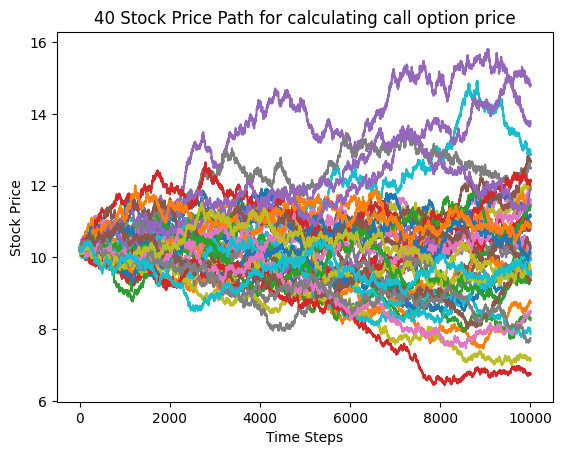

Simulation: Option price for an In-The-Money European call option: 1.488871495694059


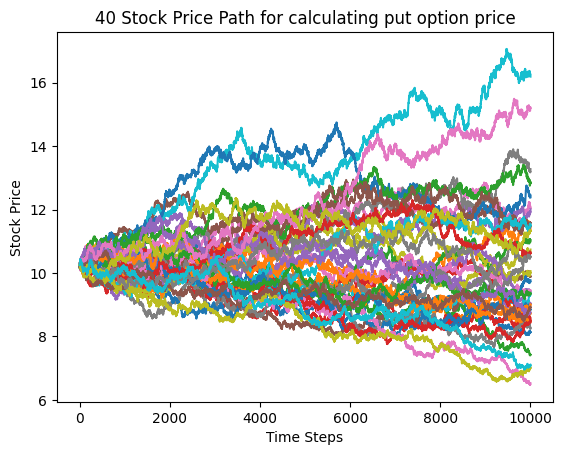

Simulation: Option price for an In-The-Money European put option: 1.4855383499265293



,model,call,put
0,Black-Scholes,1.486219,1.478775
1,CRR,1.486217,1.478808
2,Simulation,1.488871,1.485538


In [51]:

option_pricing_data_historical =  getAnalysis(S, K_call,K_put, r, T, sigma)
option_pricing_data_historical

### Task-8: We have reserved 3 marks for using other methods to estimate the volatility like GARACH or Stochastic volatility methods.

In [38]:
# estimate implied volatility using GARACH method
import matplotlib.pyplot as plt
from pmdarima.model_selection import train_test_split

from arch import arch_model
returns = df['log_ret'].dropna()
returns_rescaled = 10 * returns
model = arch_model(returns_rescaled, vol='GARCH', p=1, q=1, rescale=False)
results = model.fit(disp='off')

# Get conditional volatility forecast
forecast_volatility = results.forecast(horizon=1).variance.iloc[-1, 0]
forecast_volatility = np.sqrt(forecast_volatility)
print(f"Forecasted volatility: {forecast_volatility}")
print(f"Historical volatility: {hist_vol}")


Forecasted volatility: 0.24362437632294023
Historical volatility: 0.40456327213623305


CRR: Option price for an In-The-Money European call option: 0.0
CRR: Option price for an In-The-Money European put option: 168.9752556421695

BS Model: Option price for an In-The-Money European call option: 0.0
BS Model: Option price for an In-The-Money European put option: 168.97525564216934



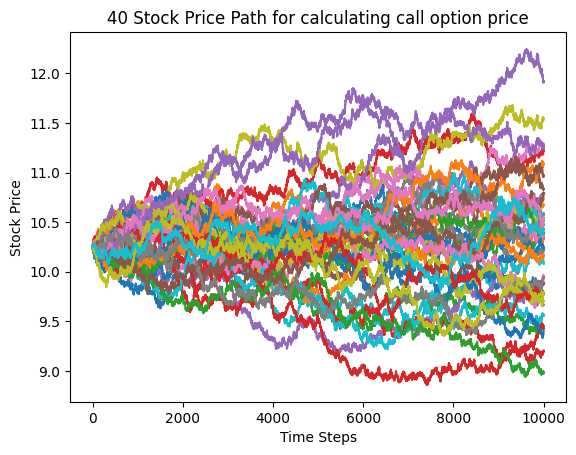

Simulation: Option price for an In-The-Money European call option: 0.0


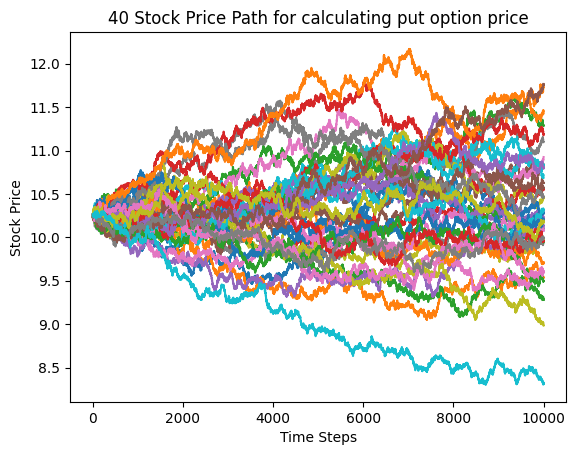

Simulation: Option price for an In-The-Money European put option: 168.99524536481235



,model,call,put
0,Black-Scholes,0.0,168.975256
1,CRR,0.0,168.975256
2,Simulation,0.0,168.995245


In [39]:

option_pricing_data_implied = getAnalysis(S, K_call,K_put, r, T, forecast_volatility)
option_pricing_data_implied

In [40]:
# create a table to compare option pricing using historical and implied volatility
print(f"sigma: {hist_vol}")
print(f"Current stock price: {S}")
print(f"risk free rate: {r}")
print(f"T: {T}")
print(f"K_call: {K_call}")
print(f"K_put: {K_put}")
print(f"Forecasted volatility: {forecast_volatility}")
option_pricing_data = pd.concat([option_pricing_data_historical, option_pricing_data_implied], keys=['using Historical volatility', 'using Implied volatility'])
option_pricing_data


sigma: 0.40456327213623305
Current stock price: 10.25
risk free rate: 0.05248000144958496
T: 0.0821917808219178
K_call: 170
K_put: 180.0
Forecasted volatility: 0.24362437632294023


model           call         put
using Historical volatility 0  Black-Scholes  3.824510e-130  168.975256
                            1            CRR   0.000000e+00  168.975256
                            2     Simulation   0.000000e+00  168.944310
using Implied volatility    0  Black-Scholes   0.000000e+00  168.975256
                            1            CRR   0.000000e+00  168.975256
                            2     Simulation   0.000000e+00  168.995245

#### Results


## Option Pricing Parameters

| Parameter | Value |
|---|---|
| sigma (Historical volatility) | 0.2873627770614688 |
| S0 (Spot Price) | 173.69000244140625 |
| r (Risk-Free Rate) | 0.052379999160766605 |
| T (Time to Maturity) | 0.09041095890410959 |
| K_call (Strike Price - Call) | 170 |
| K_put (Strike Price - Put) | 180.0 |
| sigma_hat (Forecasted Volatility) | 0.2899623910268287 |

## Option Pricing Results

| Model | volatility type | call | put |
|---| ---| ---|---|
| Black-Scholes | Historical | 8.424078 | 9.194815 |
| CRR | Historical | 8.420028 | 9.220725 |
| Simulation | Historical | 8.417756 | 9.330980 |
| Black-Scholes | Forecasted | 8.475106 | 9.246386 |
| CRR | Forecasted | 8.472379 | 9.272269 |
| Simulation | Forecasted | 8.402203 | 9.112247 |


- simulation results can vary due to the random nature of the simulation.